In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [170]:
MONTHLY_SAVING = 2000
INVESTMENT_HORIZON_MONTHS = 60
START_DATE = pd.to_datetime("1990-02-01")
END_DATE = pd.to_datetime("2025-04-25")
PERCENTILES_TO_TEST = [80, 85, 90, 95]

In [172]:
# Wczytujemy dane S&P 500 
sp500 = pd.read_csv('Data/sap500.csv', parse_dates=["Date"])

# Ograniczamy dane tylko do interesującego nas okresu
START_DATE = pd.to_datetime("1990-02-01")
END_DATE = pd.to_datetime("2025-04-25")

# Filtrujemy zakres dat
sp500 = sp500[(sp500["Date"] >= START_DATE) & (sp500["Date"] <= END_DATE)]

# Wybieramy tylko potrzebne kolumny i zmieniamy nazwę
sp500 = sp500[['Date', 'Close']].rename(columns={'Close': 'SP500_Close'})

In [174]:
# Wczytujemy dane VIX (z formatem daty mm/dd/yyyy)
vix = pd.read_csv('Data/VIX_History.csv', parse_dates=["DATE"], date_format='%m/%d/%Y')
vix = vix.rename(columns={"DATE": "Date", "CLOSE": "VIX_Close"})
vix = vix[['Date', 'VIX_Close']]

In [176]:
# Łączymy tabele i przekształcamy na dane miesięczne
df = pd.merge(sp500, vix, on='Date', how='inner')
df.set_index('Date', inplace=True)
monthly_df = df.resample('ME').last()
monthly_df.index = pd.to_datetime(monthly_df.index)

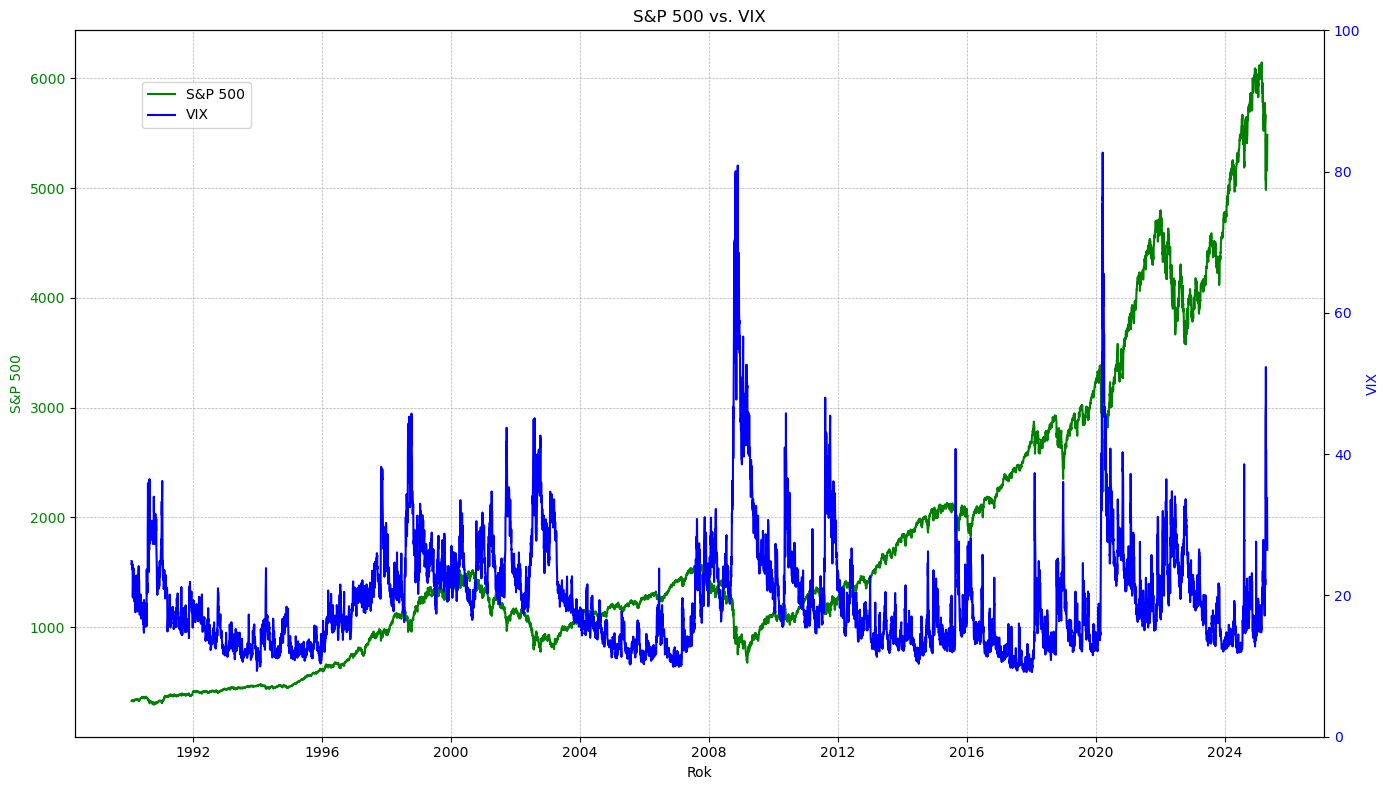

In [178]:
# Tworzymy wykres liniowy dla danych SP500 i VIX w zdefiniowanym zakresie dat
fig, ax1 = plt.subplots(figsize=(14, 8))

# Filtrujemy dane w zakresie dat
filtered_df = df[(df.index >= START_DATE) & (df.index <= END_DATE)]

# Wykres SP500
ax1.plot(filtered_df.index, filtered_df['SP500_Close'], color='green', label='S&P 500')
ax1.set_xlabel('Rok')
ax1.set_ylabel('S&P 500', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Druga oś Y dla VIX
ax2 = ax1.twinx()
ax2.plot(filtered_df.index, filtered_df['VIX_Close'], color='blue', label='VIX')
ax2.set_ylabel('VIX', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 100)

# Dodajemy legendę dla obu osi
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Tytuł wykresu
plt.title('S&P 500 vs. VIX')

# Wyświetlamy wykres
plt.tight_layout()
plt.show()

Na wykresie zwizualizowano wartości indeksów VIX i S&P 500 w analizowanym okresie czasowym. Można zauważyć, że skokowemu wzrostowi indeksu VIX towarzyszy spadek S&P 500. W momencie szczytów VIX, większość spadków indeksu S&P 500 jest już jednak zmaterializowana.

In [181]:
# Sprawdzamy korelację spearmana między indeksami
spearman_corr = monthly_df['SP500_Close'].corr(monthly_df['VIX_Close'], method='spearman')
print(f"Korelacja Spearmana między S&P 500 a VIX: {spearman_corr:.4f}")

Korelacja Spearmana między S&P 500 a VIX: -0.0479


In [183]:
# Ustawiamy daty jako indeksy i upewniamy się, że są posortowane
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500.set_index('Date', inplace=True)
sp500 = sp500.sort_index()

vix['Date'] = pd.to_datetime(vix['Date'])
vix.set_index('Date', inplace=True)
vix = vix.sort_index()

In [185]:
# Zbiór dostępnych dat notowań (dla szybkiego lookupu)
available_dates = set(sp500.index)

In [187]:
# Funkcja do znalezienia najbliższego poniedziałku z notowaniami
def find_next_monday_with_data(date):
    max_lookahead = 7  # sprawdzamy maksymalnie tydzień naprzód
    for i in range(max_lookahead):
        candidate = date + timedelta(days=i)
        if candidate.weekday() == 0 and candidate in available_dates:
            return candidate
    return None 

In [189]:
# Słownik z cenami dla szybkiego lookupu
sp500_prices = sp500['SP500_Close'].to_dict()

In [191]:
# Lista wyników
results = []

for current_date, row in sp500.iterrows():
    raw_future_date = current_date + timedelta(days=1825)
    future_date = raw_future_date

    if future_date not in available_dates:
        future_date = find_next_monday_with_data(raw_future_date)

    # Jeśli udało się znaleźć przyszłą datę w notowaniach
    
    if future_date and current_date in vix.index:
        current_price = row['SP500_Close']
        future_price = sp500_prices.get(future_date, np.nan)

        if not np.isnan(future_price):
            rate_of_return = (future_price - current_price) / current_price
            vix_value = vix.loc[current_date, 'VIX_Close']

            results.append({
                'Date': current_date,
                'VIX_Close': vix_value,
                'Return_5y': rate_of_return
            })

In [193]:
# Tworzymy DataFrame z wynikami
results_df = pd.DataFrame(results)

In [195]:
# Obliczamy korelację Pearsona
correlation = results_df['VIX_Close'].corr(results_df['Return_5y'], method='spearman')

print(f"Korelacja Spearmana między poziomem VIX a 5-letnią stopą zwrotu S&P 500: {correlation:.4f}")

Korelacja Spearmana między poziomem VIX a 5-letnią stopą zwrotu S&P 500: -0.1799


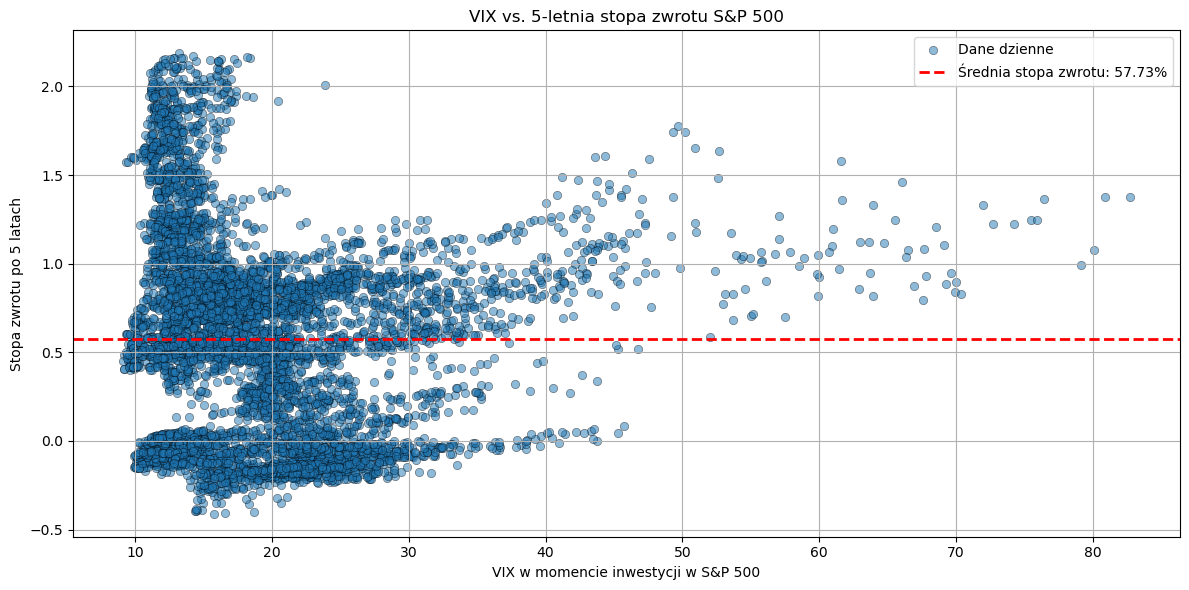

In [197]:
# Obliczamy średnią stopę zwrotu 5-letnią
mean_return = results_df['Return_5y'].mean()

# Wykres
plt.figure(figsize=(12, 6))

# Punkty
sns.scatterplot(
    data=results_df,
    x='VIX_Close',
    y='Return_5y',
    alpha=0.5,
    edgecolor='k',
    label='Dane dzienne'
)

# Pozioma linia średniej stopy zwrotu
plt.axhline(mean_return, color='red', linestyle='--', linewidth=2, label=f'Średnia stopa zwrotu: {mean_return:.2%}')

plt.title(f'VIX vs. 5-letnia stopa zwrotu S&P 500')
plt.xlabel('VIX w momencie inwestycji w S&P 500')
plt.ylabel('Stopa zwrotu po 5 latach')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [199]:
# Średnia 5-letnia stopa zwrotu
mean_return = results_df['Return_5y'].mean()

# Zaokrąglamy VIX do 0.1 dla stabilności
vix_levels = sorted(results_df['VIX_Close'].round(1).unique())

# Szukamy najniższego progu VIX, przy którym wszystkie zwroty > średniej
safe_vix_level = None

for threshold in vix_levels:
    subset = results_df[results_df['VIX_Close'] >= threshold]
    if not subset.empty and (subset['Return_5y'] > mean_return).all():
        safe_vix_level = threshold
        break

if safe_vix_level:
    print(f" Dla VIX >= {safe_vix_level}, 5-letnia stopa zwrotu ZAWSZE była wyższa niż średnia ({mean_return:.2%})")
else:
    print("Nie znaleziono poziomu VIX, przy którym każda 5-letnia stopa zwrotu byłaby wyższa niż średnia.")

 Dla VIX >= 46.8, 5-letnia stopa zwrotu ZAWSZE była wyższa niż średnia (57.73%)


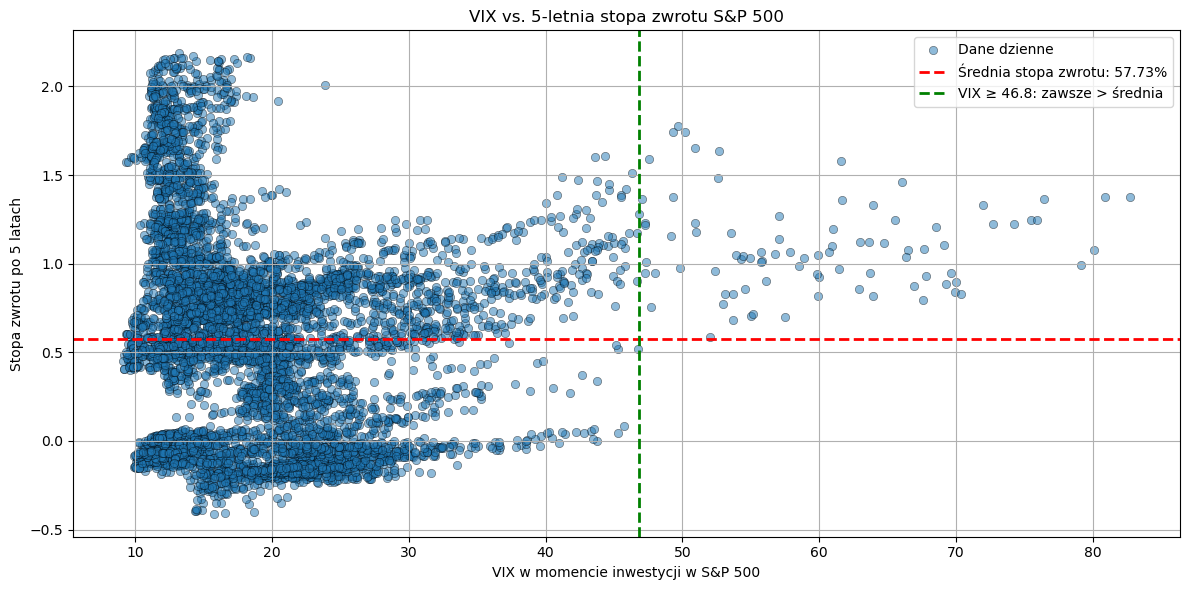

In [201]:
# Tworzymy wykres
plt.figure(figsize=(12, 6))

sns.scatterplot(
    data=results_df,
    x='VIX_Close',
    y='Return_5y',
    alpha=0.5,
    edgecolor='k',
    label='Dane dzienne'
)

# Pozioma linia średniej
plt.axhline(mean_return, color='red', linestyle='--', linewidth=2, label=f'Średnia stopa zwrotu: {mean_return:.2%}')

# Pionowa linia safe vix level
if safe_vix_level:
    plt.axvline(safe_vix_level, color='green', linestyle='--', linewidth=2,
                label=f'VIX ≥ {safe_vix_level:.1f}: zawsze > średnia')

# Opisy i układ
plt.title(f'VIX vs. 5-letnia stopa zwrotu S&P 500')
plt.xlabel('VIX w momencie inwestycji w S&P 500')
plt.ylabel('Stopa zwrotu po 5 latach')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [203]:
# Sprawdzamy liczbę odczytów VIX >= 46.8
count_high_vix = (vix['VIX_Close'] >= safe_vix_level).sum()
print(f"Liczba dni, w których VIX był ≥ 46.8: {count_high_vix}")

Liczba dni, w których VIX był ≥ 46.8: 92


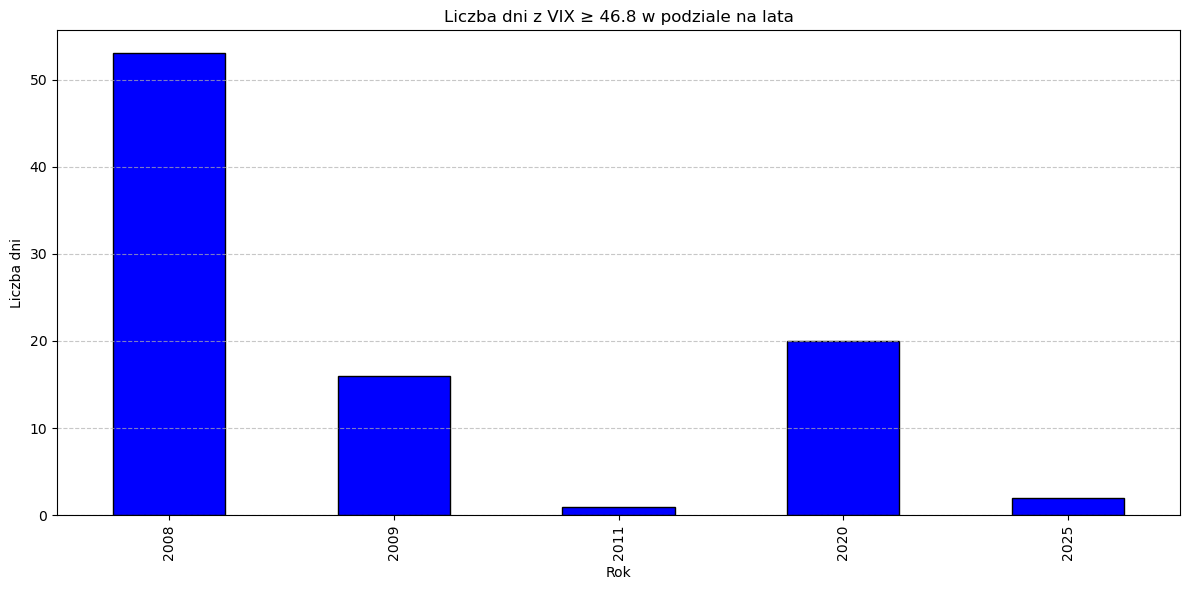

In [205]:
# Filtrowanie dni z VIX >= 46.8
high_vix = vix[vix['VIX_Close'] >= safe_vix_level].copy()

# Dodajemy kolumnę z rokiem
high_vix['Year'] = high_vix.index.year

# Grupujemy po roku i liczymy liczbę dni
vix_counts_by_year = high_vix.groupby('Year').size()

# Wykres słupkowy
plt.figure(figsize=(12, 6))
vix_counts_by_year.plot(kind='bar', color='blue', edgecolor='black')

# Opisy
plt.title('Liczba dni z VIX ≥ 46.8 w podziale na lata')
plt.xlabel('Rok')
plt.ylabel('Liczba dni')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [207]:
# Strategia regularna – kupujemy co miesiąc przez 5 lat, sprzedajemy na końcu
def simulate_regular_portfolio(data, START_DATE):
    total_invested = 0
    total_units = 0
    END_DATE = START_DATE + pd.DateOffset(months=INVESTMENT_HORIZON_MONTHS)

    for i in range(INVESTMENT_HORIZON_MONTHS):
        date = START_DATE + pd.DateOffset(months=i)
        if date in data.index:
            price = data.loc[date]['SP500_Close']
            units = MONTHLY_SAVING / price
            total_units += units
            total_invested += MONTHLY_SAVING

    if END_DATE in data.index:
        final_price = data.loc[END_DATE]['SP500_Close']
        portfolio_value = total_units * final_price
        return (portfolio_value - total_invested) / total_invested * 100
    return None

In [209]:
#Strategie VIX, sprawdzamy wartość percentyli
# Obliczamy percentyle
percentiles = [80, 85, 90, 95]
vix_percentile_values = np.percentile(vix['VIX_Close'].dropna(), percentiles)

# Wypisujemy
for p, val in zip(percentiles, vix_percentile_values):
    print(f"{p}. percentyl VIX = {val:.2f}")

80. percentyl VIX = 24.31
85. percentyl VIX = 26.06
90. percentyl VIX = 28.71
95. percentyl VIX = 33.20


In [211]:
# Strategia VIX – inwestujemy tylko gdy VIX > próg, trzymamy wszystko do końca horyzontu
def simulate_vix_strategy_portfolio(data, vix_cutoff, START_DATE):
    END_DATE = START_DATE + pd.DateOffset(months=INVESTMENT_HORIZON_MONTHS)
    current_year = START_DATE.year
    last_investment_year = None

    savings = 0
    total_units = 0
    total_invested = 0

    for date in data.loc[START_DATE:END_DATE].index:
        row = data.loc[date]
        savings += MONTHLY_SAVING

        if last_investment_year != date.year:
            if row['VIX_Close'] > vix_cutoff:
                price = row['SP500_Close']
                units = savings / price
                total_units += units
                total_invested += savings
                savings = 0
                last_investment_year = date.year

    # Sprawdzamy, czy inwestycje zostały dokonane
    if total_invested == 0:
        return None  # Jeśli nie było inwestycji, zwróć None

    # Po 5 latach wartość całego portfela
    if END_DATE in data.index:
        final_price = data.loc[END_DATE]['SP500_Close']
        portfolio_value = total_units * final_price
        return (portfolio_value - total_invested) / total_invested * 100

    return None

In [217]:
# Uruchamiamy symulacje dla wielu startowych dat
start_dates = monthly_df.index[:-INVESTMENT_HORIZON_MONTHS]

regular_results = []
vix_results = {p: [] for p in PERCENTILES_TO_TEST}

for START_DATE in start_dates:
    r = simulate_regular_portfolio(monthly_df, START_DATE)
    if r is not None:
        regular_results.append(r)

    for p in PERCENTILES_TO_TEST:
        cutoff = monthly_df['VIX_Close'].quantile(p / 100)
        vr = simulate_vix_strategy_portfolio(monthly_df, cutoff, START_DATE)
        if vr is not None:
            vix_results[p].append(vr)

In [223]:
# Wyniki: średnia stopa zwrotu i odchylenie standardowe
regular_mean = np.mean(regular_results)
regular_std = np.std(regular_results)

vix_means = {p: np.mean(vix_results[p]) for p in PERCENTILES_TO_TEST}
vix_stds = {p: np.std(vix_results[p]) for p in PERCENTILES_TO_TEST}

print(f"Regularna: Średnia = {regular_mean:.2f}%, Odchylenie std = {regular_std:.2f}%")
for p in PERCENTILES_TO_TEST:
    print(f"VIX > {p}%: Średnia = {vix_means[p]:.2f}%, Odchylenie std = {vix_stds[p]:.2f}%")

Regularna: Średnia = 28.19%, Odchylenie std = 27.47%
VIX > 80%: Średnia = 25.42%, Odchylenie std = 26.23%
VIX > 85%: Średnia = 26.79%, Odchylenie std = 26.90%
VIX > 90%: Średnia = 29.82%, Odchylenie std = 28.51%
VIX > 95%: Średnia = 31.04%, Odchylenie std = 28.74%


In [225]:
# Funkcja do liczenia przypadków w określonych przedziałach
def count_cases_in_ranges(results, ranges):
    counts = {}
    for r in ranges:
        counts[r] = np.sum((np.array(results) >= r[0]) & (np.array(results) < r[1]))
    return counts

# Definiujemy przedziały
ranges = [(50, 60), (60, 70), (80, 200)]

# Liczymy przypadki dla strategii regularnej
regular_counts = count_cases_in_ranges(regular_results, ranges)

# Liczymy przypadki dla strategii VIX
vix_counts = {p: count_cases_in_ranges(vix_results[p], ranges) for p in PERCENTILES_TO_TEST}

# Wyświetlamy wyniki
print("Liczba przypadków w przedziałach dla strategii regularnej:")
for r in ranges:
    print(f"Stopa zwrotu {r[0]}% - {r[1]}%: {regular_counts[r]} przypadków")

for p in PERCENTILES_TO_TEST:
    print(f"\nLiczba przypadków w przedziałach dla VIX > {p}%:")
    for r in ranges:
        print(f"Stopa zwrotu {r[0]}% - {r[1]}%: {vix_counts[p][r]} przypadków")

Liczba przypadków w przedziałach dla strategii regularnej:
Stopa zwrotu 50% - 60%: 25 przypadków
Stopa zwrotu 60% - 70%: 9 przypadków
Stopa zwrotu 80% - 200%: 17 przypadków

Liczba przypadków w przedziałach dla VIX > 80%:
Stopa zwrotu 50% - 60%: 22 przypadków
Stopa zwrotu 60% - 70%: 29 przypadków
Stopa zwrotu 80% - 200%: 5 przypadków

Liczba przypadków w przedziałach dla VIX > 85%:
Stopa zwrotu 50% - 60%: 24 przypadków
Stopa zwrotu 60% - 70%: 19 przypadków
Stopa zwrotu 80% - 200%: 5 przypadków

Liczba przypadków w przedziałach dla VIX > 90%:
Stopa zwrotu 50% - 60%: 30 przypadków
Stopa zwrotu 60% - 70%: 25 przypadków
Stopa zwrotu 80% - 200%: 4 przypadków

Liczba przypadków w przedziałach dla VIX > 95%:
Stopa zwrotu 50% - 60%: 29 przypadków
Stopa zwrotu 60% - 70%: 11 przypadków
Stopa zwrotu 80% - 200%: 24 przypadków


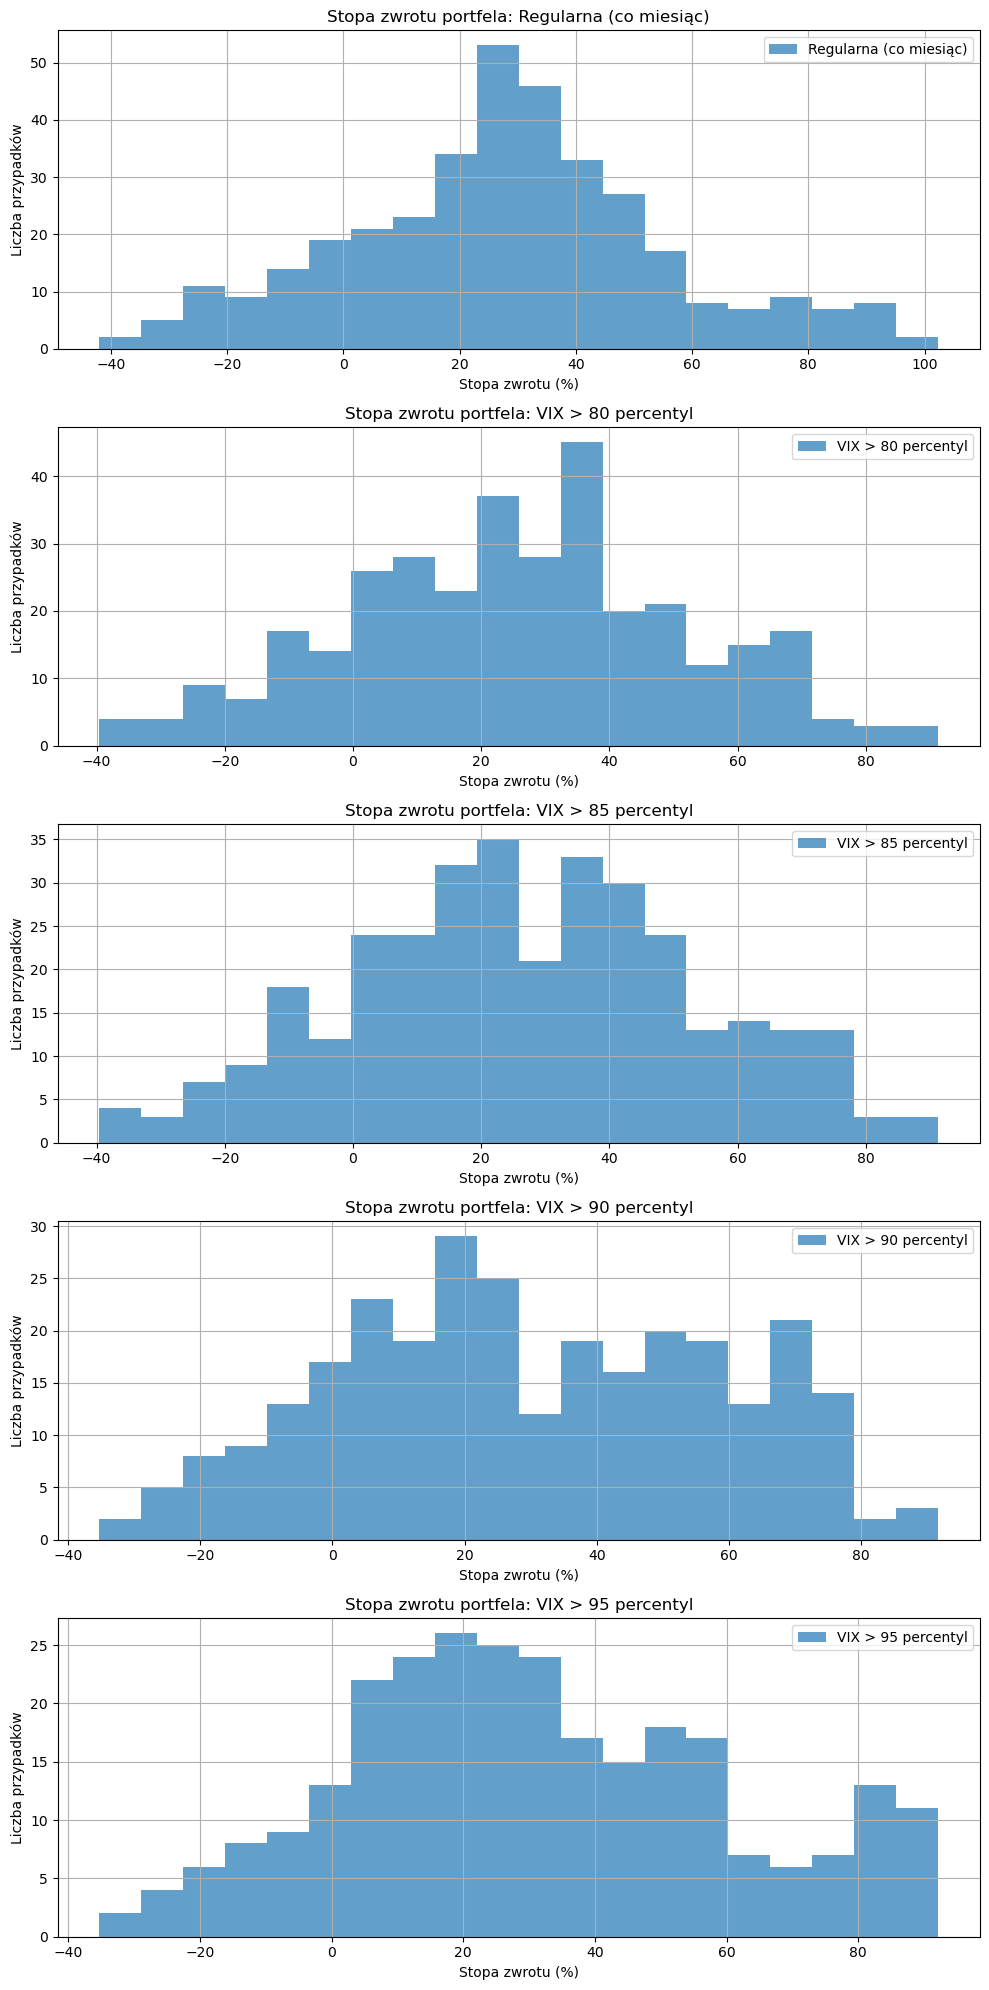

In [229]:
# Histogram dotyczący wszystkich przypadków symulacji
def plot_histogram(results, label, ax):
    ax.hist(results, bins=20, alpha=0.7, label=label)
    ax.set_title(f'Stopa zwrotu portfela: {label}')
    ax.set_xlabel('Stopa zwrotu (%)')
    ax.set_ylabel('Liczba przypadków')
    ax.grid(True)
    ax.legend()

# Tworzymy wykresy histogramów dla każdego wariantu na osobnych wykresach
fig, axs = plt.subplots(len(PERCENTILES_TO_TEST) + 1, 1, figsize=(10, 20))  # Plus 1 dla Regularnej

# Wykres dla strategii regularnej
plot_histogram(regular_results, 'Regularna (co miesiąc)', axs[0])

# Wykresy dla poszczególnych wartości VIX
for i, p in enumerate(PERCENTILES_TO_TEST):
    plot_histogram(vix_results[p], f'VIX > {p} percentyl', axs[i + 1])

plt.tight_layout()
plt.show()

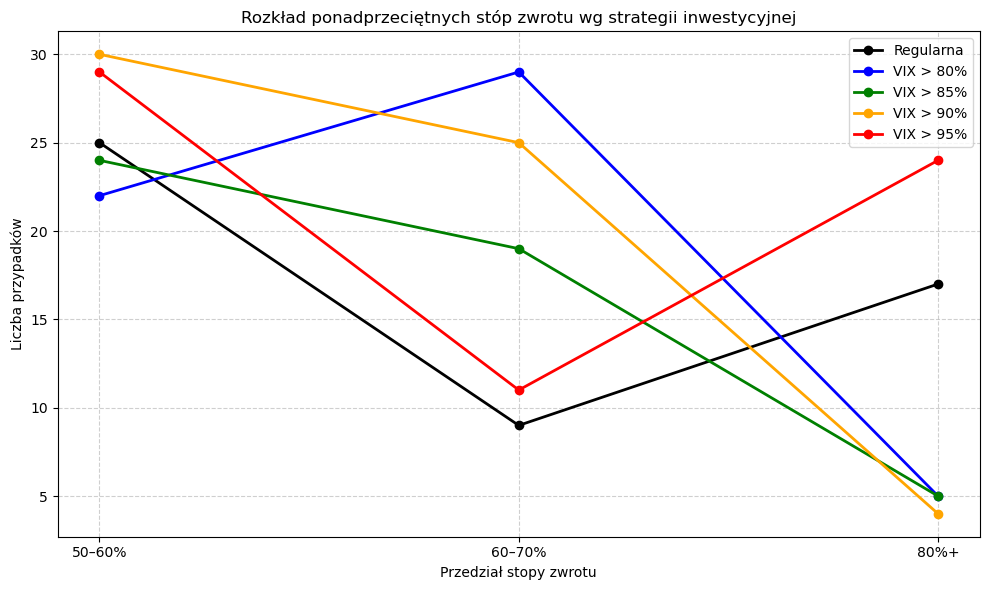

In [231]:
# Etykiety przedziałów
range_labels = ['50–60%', '60–70%', '80%+']

# Strategie
strategies = ['Regularna'] + [f'VIX > {p}%' for p in PERCENTILES_TO_TEST]
all_data = [ [regular_counts[r] for r in ranges] ] + [
    [vix_counts[p][r] for r in ranges] for p in PERCENTILES_TO_TEST
]

# Wykres
plt.figure(figsize=(10, 6))

colors = ['black', 'blue', 'green', 'orange', 'red']

# Rysujemy każdą serię danych jako linię
for i, data in enumerate(all_data):
    plt.plot(range_labels, data, marker='o', linewidth=2, color=colors[i], label=strategies[i])

plt.xlabel('Przedział stopy zwrotu')
plt.ylabel('Liczba przypadków')
plt.title('Rozkład ponadprzeciętnych stóp zwrotu wg strategii inwestycyjnej')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

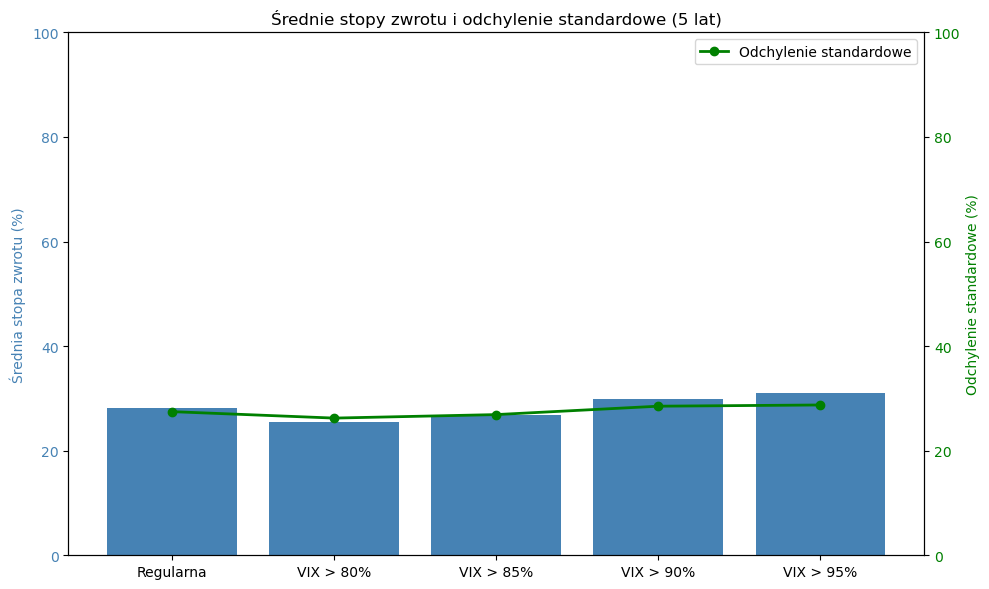

In [233]:
# Wykres średnich stóp zwrotu i odchylenia standardowego

means = [regular_mean] + [vix_means[p] for p in PERCENTILES_TO_TEST]
stds = [regular_std] + [vix_stds[p] for p in PERCENTILES_TO_TEST]
labels = ['Regularna'] + [f'VIX > {p}%' for p in PERCENTILES_TO_TEST]

# Wykres z dwoma osiami Y
fig, ax1 = plt.subplots(figsize=(10, 6))

# Słupki: średnia stopa zwrotu (lewa oś Y)
bars = ax1.bar(labels, means, color='steelblue')
ax1.set_ylabel('Średnia stopa zwrotu (%)', color='steelblue')
ax1.set_ylim(0, 100)
ax1.tick_params(axis='y', labelcolor='steelblue')

# Druga oś Y: odchylenie standardowe jako linia
ax2 = ax1.twinx()
ax2.set_ylabel('Odchylenie standardowe (%)', color='green')  
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', labelcolor='green') 

# Rysujemy linię z punktami (odchylenie standardowe)
ax2.plot(labels, stds, color='green', marker='o', linewidth=2, label='Odchylenie standardowe')

plt.title('Średnie stopy zwrotu i odchylenie standardowe (5 lat)')
plt.xticks(rotation=45)
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [239]:
# Obliczamy ilośc inwestycji
def count_vix_investments(data, vix_cutoff, START_DATE):
    END_DATE = START_DATE + pd.DateOffset(months=INVESTMENT_HORIZON_MONTHS)
    current_year = START_DATE.year
    last_investment_year = None

    count = 0
    savings = 0

    for date in data.loc[START_DATE:END_DATE].index:
        row = data.loc[date]
        savings += MONTHLY_SAVING

        if last_investment_year != date.year:
            if row['VIX_Close'] > vix_cutoff:
                count += 1
                savings = 0
                last_investment_year = date.year

    return count

In [241]:
# Zbieramy liczbę inwestycji
investment_counts = {p: [] for p in PERCENTILES_TO_TEST}
for START_DATE in start_dates:
    for p in PERCENTILES_TO_TEST:
        cutoff = monthly_df['VIX_Close'].quantile(p / 100)
        count = count_vix_investments(monthly_df, cutoff, START_DATE)
        investment_counts[p].append(count)

In [243]:
# Średnie liczby inwestycji
print("\n Średnia liczba inwestycji (w ciągu 5 lat):")
for p in PERCENTILES_TO_TEST:
    avg_inv = np.mean(investment_counts[p])
    print(f"VIX > {p}%: {avg_inv:.2f} razy")


 Średnia liczba inwestycji (w ciągu 5 lat):
VIX > 80%: 2.84 razy
VIX > 85%: 2.61 razy
VIX > 90%: 2.21 razy
VIX > 95%: 1.78 razy


In [245]:
# Kategoryzacja liczby inwestycji
def categorize_investments(counts):
    bins = {
        '0': 0,
        '1': 0,
        '2': 0,
        '3': 0,
        '4': 0,
        '5+': 0
    }
    for c in counts:
        if c == 0:
            bins['0'] += 1
        elif c == 1:
            bins['1'] += 1
        elif c == 2:
            bins['2'] += 1
        elif c == 3:
            bins['3'] += 1
        elif c == 4:
            bins['4'] += 1
        else:
            bins['5+'] += 1
    return bins

# Zbieramy dane dla każdej strategii
investment_distribution = {
    p: categorize_investments(investment_counts[p]) for p in PERCENTILES_TO_TEST
}

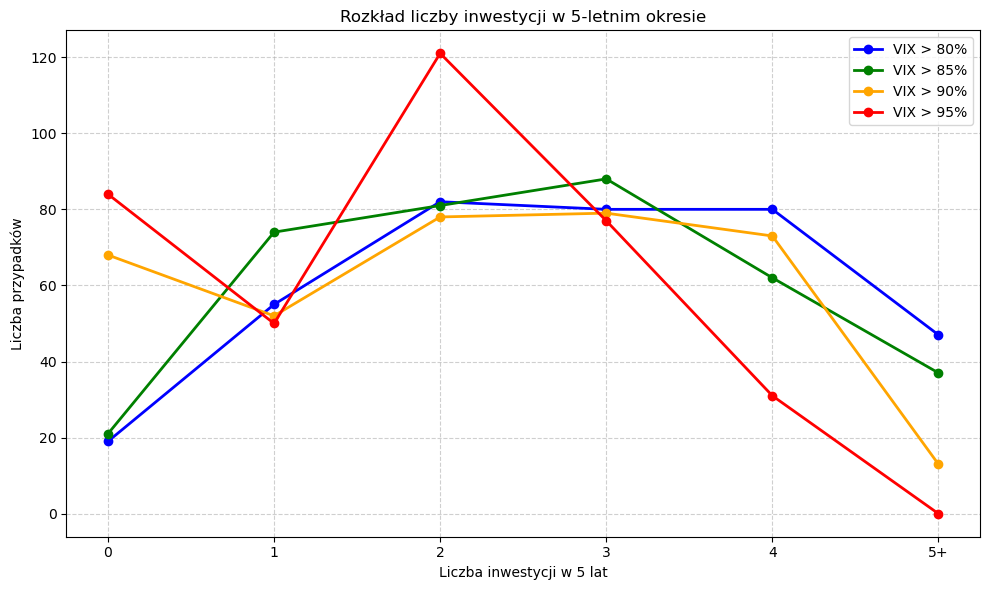

In [247]:
categories = ['0', '1', '2', '3', '4', '5+']
strategies = [f'VIX > {p}%' for p in PERCENTILES_TO_TEST]
colors = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(10, 6))

# Rysujemy linię dla każdej strategii
for i, p in enumerate(PERCENTILES_TO_TEST):
    values = [investment_distribution[p][cat] for cat in categories]
    plt.plot(categories, values, marker='o', label=strategies[i], linewidth=2, color=colors[i])

plt.title('Rozkład liczby inwestycji w 5-letnim okresie')
plt.xlabel('Liczba inwestycji w 5 lat')
plt.ylabel('Liczba przypadków')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

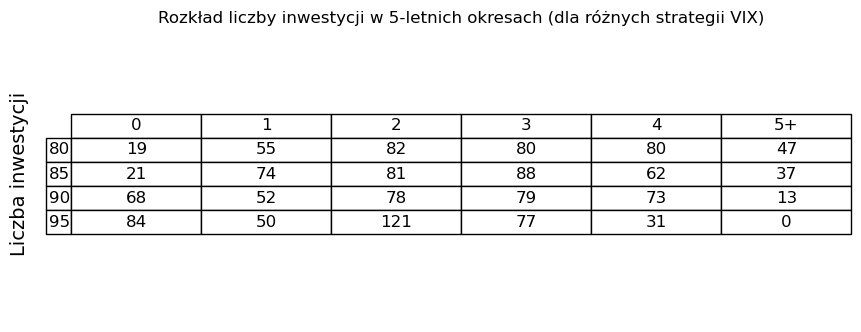

In [253]:
# Tworzymy tabelę z rozkładem inwestycji
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')

# Rysujemy tabelę
table = ax.table(
    cellText=investment_table.values,
    rowLabels=investment_table.index,
    colLabels=investment_table.columns,
    cellLoc='center',
    loc='center'
)

# Powiększamy czcionki
table.auto_set_font_size(False)
table.set_fontsize(12)

# Skalowanie komórek
table.scale(1.2, 1.5)

# Przesuwamy i dodajemy nazwę wierszy po lewej, ale z większym odsunięciem
ax.text(-0.18, 0.5, 'Liczba inwestycji', va='center', ha='center', rotation=90, fontsize=14, transform=ax.transAxes)

# Tytuł wykresu wyżej, bez kolizji z tabelą
plt.title('Rozkład liczby inwestycji w 5-letnich okresach (dla różnych strategii VIX)', pad=1)

# Zwiększamy marginesy, aby nic się nie nakładało
plt.subplots_adjust(left=0.25, top=0.85)

plt.show()

In [ ]:
#obliczamy drawdown dla tych scenariuszy w celu oszacowania ryzyka
def calculate_drawdown(portfolio_values):
    running_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - running_max) / running_max
    max_drawdown = drawdowns.min()
    return max_drawdown

# Obliczamy drawdown dla strategii regularnej
regular_drawdowns = []
for START_DATE in start_dates:
    portfolio_values = []
    for i in range(INVESTMENT_HORIZON_MONTHS):
        date = START_DATE + pd.DateOffset(months=i)
        if date in monthly_df.index:
            portfolio_values.append(monthly_df.loc[date]['SP500_Close'])
    if portfolio_values:
        regular_drawdowns.append(calculate_drawdown(np.array(portfolio_values)))

# Obliczamy drawdown dla strategii VIX
vix_drawdowns = {p: [] for p in PERCENTILES_TO_TEST}
for p in PERCENTILES_TO_TEST:
    for START_DATE in start_dates:
        portfolio_values = []
        savings = 0
        for i in range(INVESTMENT_HORIZON_MONTHS):
            date = START_DATE + pd.DateOffset(months=i)
            if date in monthly_df.index:
                row = monthly_df.loc[date]
                savings += MONTHLY_SAVING
                if row['VIX_Close'] > monthly_df['VIX_Close'].quantile(p / 100):
                    portfolio_values.append(row['SP500_Close'])
                    savings = 0
        if portfolio_values:
            vix_drawdowns[p].append(calculate_drawdown(np.array(portfolio_values)))

# Wyświetlamy wyniki drawdown
print("Maksymalny drawdown dla strategii regularnej:")
print(f"Średni drawdown: {np.mean(regular_drawdowns):.2%}, Maksymalny drawdown: {np.min(regular_drawdowns):.2%}")

for p in PERCENTILES_TO_TEST:
    print(f"\nMaksymalny drawdown dla strategii VIX > {p}%:")
    print(f"Średni drawdown: {np.mean(vix_drawdowns[p]):.2%}, Maksymalny drawdown: {np.min(vix_drawdowns[p]):.2%}")